# Project 3 - Sequential Classification
*Noah Trilling*

In [ ]:
import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Conv1D, MaxPooling1D, Flatten, Dropout, LSTM, Bidirectional
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

the_answer = 42

## Download and Explore the Data

Use Scipy’s loadmat() function to load the files, i.e. from scipy.io import loadmat. Start by loading some the recordings and plotting them.

In [ ]:
mat_files = glob.glob('./training2017/*.mat')
x = [loadmat(f) for f in mat_files]

C:\Users\NoahMSOE\AppData\Local\Temp\ipykernel_20576\594223031.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


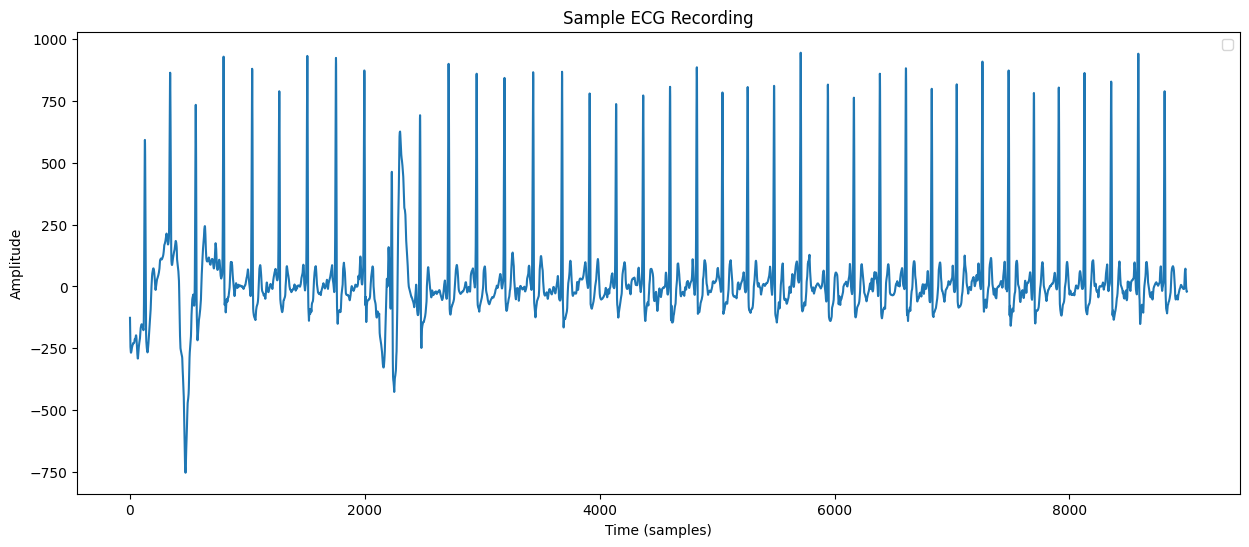

C:\Users\NoahMSOE\AppData\Local\Temp\ipykernel_20576\594223031.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


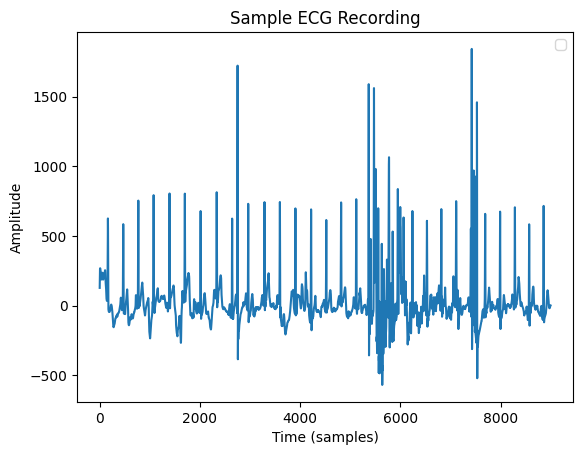

C:\Users\NoahMSOE\AppData\Local\Temp\ipykernel_20576\594223031.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


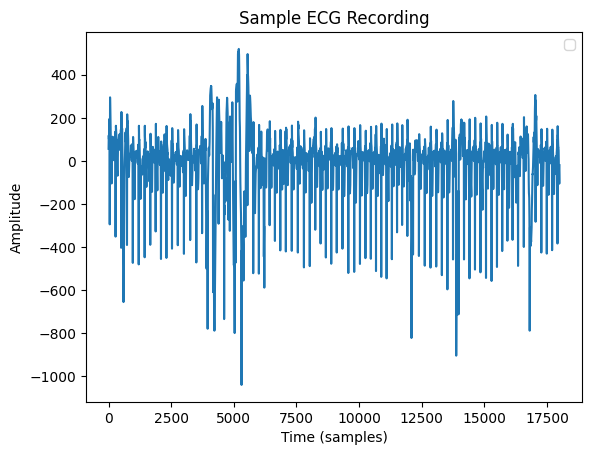

In [ ]:
plt.figure(figsize=(15, 6))
for i in range(3):
    signal = x[i]['val'].squeeze()
    sns.lineplot(x=range(len(signal)), y=signal)
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.title('Sample ECG Recording')
    plt.legend()
    plt.show()


Count the total number of recordings to ensure that it matches the number given above.

In [ ]:
print(f"Total number of recordings: {len(x)}")

Total number of recordings: 8528


Generate a table and count plot for the number of recordings in each category.

category
N    5154
O    2557
A     771
~      46
Name: count, dtype: int64

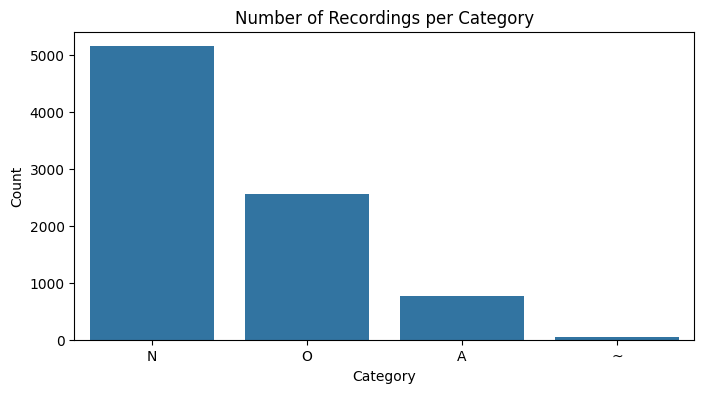

In [ ]:
y_df = pd.read_csv('./training2017/REFERENCE.csv', names=['recording', 'category'])
category_counts = y_df['category'].value_counts()
display(category_counts)

plt.figure(figsize=(8, 4))
sns.countplot(x='category', data=y_df, order=category_counts.index)
plt.title('Number of Recordings per Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

Look at the distribution of lengths of the recordings – are they the same?

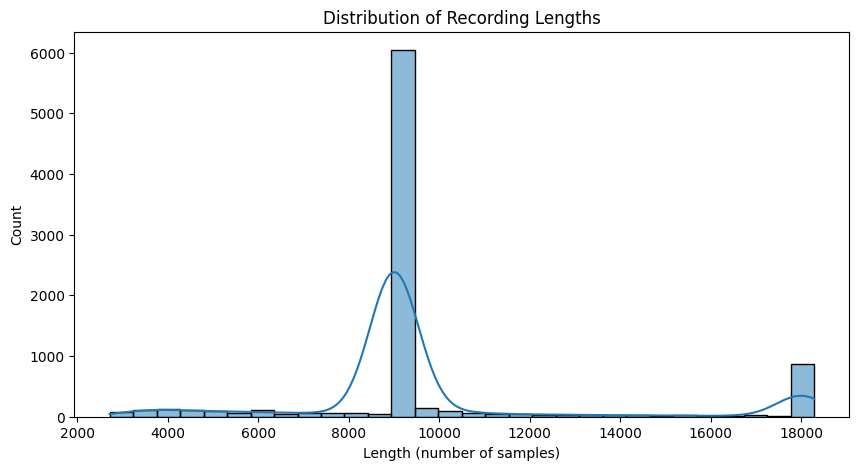

In [ ]:
lengths = [d['val'].shape[1] for d in x]

plt.figure(figsize=(10, 5))
sns.histplot(lengths, bins=30, kde=True)
plt.title('Distribution of Recording Lengths')
plt.xlabel('Length (number of samples)')
plt.ylabel('Count')
plt.show()

## Build several machine learning models to classify this data

### Data Preprocessing

The ECG sequences are not the same length. There are model architectures available for dealing with sequences of arbitrary length, but for simplicity we will preprocess these sequences so that they have the same length. There are many possible ways to do this, for example:

Pad the end of each sequence with zeros to make it the length of the longest
overall sequence;

Take the first t data points for each sequence, where t is the length of the
shortest sequence;

Sample a window of each sequence of length t, where t is less than or equal to the length of the shortest sequence;

Choose and implement a strategy for making the sequences the same length.

In [ ]:
min_len = min(lengths)

x = np.array([
    d['val'].squeeze()[:min_len]
    for d in x
])

print(f"Trimmed sequences shape: {x.shape}")

Padded sequences shape: (8528, 18286)


Split the data into training, validation, and testing sets.

In [ ]:
y = y_df['category'].values

# Split into train (70%), temp (30%)
x_train, x_temp, y_train, y_temp = train_test_split(
    x, y, test_size=0.2, random_state=the_answer, stratify=y
)

# Split temp into validation (15%) and test (15%)
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=the_answer, stratify=y_temp
)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)

y_train = to_categorical(y_train_enc)
y_val = to_categorical(y_val_enc)
y_test = to_categorical(y_test_enc)

### Dense Neural Network

Use Keras to build a dense NN to classify these sequences. Begin with a single hidden layer. Use accuracy as your metric and Adam as your optimizer.

In [ ]:
model = Sequential([
    Input(shape=(x_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=10,
    batch_size=32
)

Epoch 1/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.4488 - loss: 501.7684 - val_accuracy: 0.4959 - val_loss: 239.5701
Epoch 2/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6706 - loss: 58.2669 - val_accuracy: 0.4361 - val_loss: 157.2373
Epoch 3/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7240 - loss: 24.2882 - val_accuracy: 0.4853 - val_loss: 145.0178
Epoch 4/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7655 - loss: 12.5360 - val_accuracy: 0.5170 - val_loss: 122.3856
Epoch 5/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7900 - loss: 10.1754 - val_accuracy: 0.4455 - val_loss: 150.7992
Epoch 6/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8078 - loss: 10.3696 - val_accuracy: 0.5182 - val_loss: 143.1402
Epoch 7/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8334 - loss: 6.5592 - val_accuracy: 0.5428 - val_loss: 162.0778
Epoch 8/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8193 - lo

#### DNN Metrics

All the metrics should be generated after predicting on the testing set.

In [ ]:
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


Compute the F1 score for each class.

In [ ]:
f1_per_class = f1_score(y_test_enc, y_pred, average=None)
for idx, score in enumerate(f1_per_class):
    print(f"F1 score for class {le.inverse_transform([idx])[0]}: {score}")

F1 score for class A: 0.15873015873015872
F1 score for class N: 0.6314831665150137
F1 score for class O: 0.2536997885835095
F1 score for class ~: 0.0


Compute and report the overall F1 score as the average of the computed F1 scores.

In [ ]:
overall_f1 = np.mean(f1_per_class)
print(f"Overall F1 score (average across classes): {overall_f1:.4f}")

Overall F1 score (average across classes): 0.2610


Report the AUC score.

In [ ]:
auc_score = roc_auc_score(y_test, y_pred_probs, average='macro', multi_class='ovr')
print(f"AUC score (macro, one-vs-rest): {auc_score:.4f}")

AUC score (macro, one-vs-rest): 0.5159


Also, construct confusion matrices.

<Figure size 600x600 with 0 Axes>

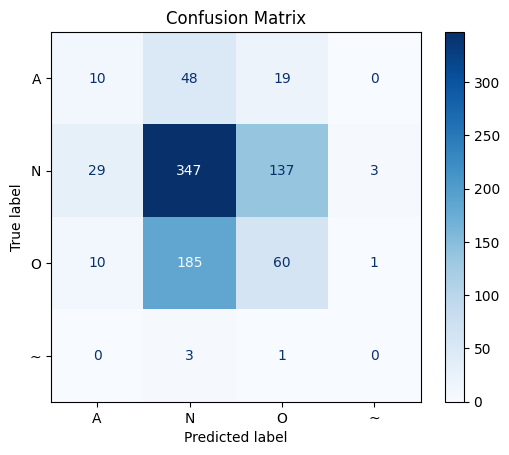

In [ ]:
cm = confusion_matrix(y_test_enc, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

### Convolutional Neural Network

Use Keras to build a second deep learning model, using convolutional neural
networks, to classify these sequences. Use accuracy as your metric and Adam as your
optimizer.

In [ ]:
x_train_cnn = x_train[..., np.newaxis]
x_val_cnn = x_val[..., np.newaxis]
x_test_cnn = x_test[..., np.newaxis]

cnn_model = Sequential([
    Input(shape=(x_train_cnn.shape[1], 1)),
    Conv1D(32, kernel_size=7, activation='relu'),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

cnn_history = cnn_model.fit(
    x_train_cnn, y_train,
    validation_data=(x_val_cnn, y_val),
    epochs=10,
    batch_size=32
)

Epoch 1/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 60s 269ms/step - accuracy: 0.5426 - loss: 63.1748 - val_accuracy: 0.6038 - val_loss: 1.2529
Epoch 2/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 57s 264ms/step - accuracy: 0.5967 - loss: 1.3012 - val_accuracy: 0.6038 - val_loss: 1.1514
Epoch 3/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 56s 263ms/step - accuracy: 0.6095 - loss: 1.1304 - val_accuracy: 0.6038 - val_loss: 1.0821
Epoch 4/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 56s 263ms/step - accuracy: 0.6080 - loss: 1.0660 - val_accuracy: 0.6038 - val_loss: 1.0351
Epoch 5/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 462s 2s/step - accuracy: 0.6120 - loss: 1.0220 - val_accuracy: 0.6038 - val_loss: 1.0037
Epoch 6/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 57s 267ms/step - accuracy: 0.5936 - loss: 1.0071 - val_accuracy: 0.6038 - val_loss: 0.9826
Epoch 7/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 56s 263ms/step - accuracy: 0.6091 - loss: 0.9759 - val_accuracy: 0.6038 - val_loss: 0.9677
Epoch 8/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 56s 262ms/step - accuracy: 0.5958 - loss: 0.

#### CNN Metrics

All the metrics should be generated after predicting on the testing set.

In [ ]:
cnn_y_pred_probs = cnn_model.predict(x_test_cnn)
cnn_y_pred = np.argmax(cnn_y_pred_probs, axis=1)

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step


Compute the F1 score for each class.

In [ ]:
cnn_f1_per_class = f1_score(y_test_enc, cnn_y_pred, average=None)
for idx, score in enumerate(cnn_f1_per_class):
    print(f"F1 score for class {le.inverse_transform([idx])[0]}: {score}")

F1 score for class A: 0.0
F1 score for class N: 0.7538349159970782
F1 score for class O: 0.0
F1 score for class ~: 0.0


Compute and report the overall F1 score as the average of the computed F1 scores.

In [ ]:
cnn_overall_f1 = np.mean(cnn_f1_per_class)
print(f"Overall F1 score (average across classes): {cnn_overall_f1:.4f}")

Overall F1 score (average across classes): 0.1885


Report the AUC score.

In [ ]:
cnn_auc_score = roc_auc_score(y_test, cnn_y_pred_probs, average='macro', multi_class='ovr')
print(f"CNN AUC score (macro, one-vs-rest): {cnn_auc_score:.4f}")

CNN AUC score (macro, one-vs-rest): 0.5000


Also, construct confusion matrices.

<Figure size 600x600 with 0 Axes>

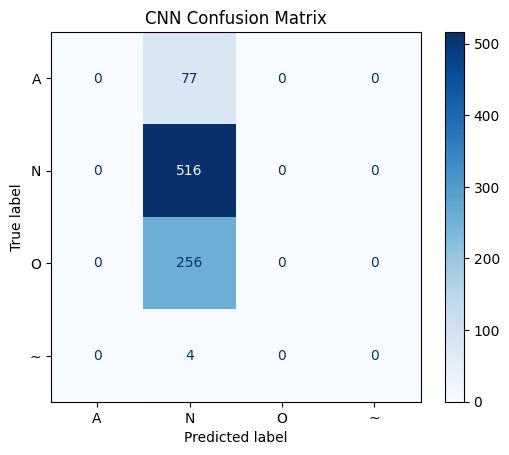

In [ ]:
cnn_cm = confusion_matrix(y_test_enc, cnn_y_pred)
cnn_disp = ConfusionMatrixDisplay(confusion_matrix=cnn_cm, display_labels=le.classes_)
plt.figure(figsize=(6, 6))
cnn_disp.plot(cmap='Blues', values_format='d')
plt.title('CNN Confusion Matrix')
plt.show()

### Alternative Model

Use Keras to build another machine learning model of your choice to classify these sequences.

In [ ]:
x_train_lstm = x_train[..., np.newaxis]
x_val_lstm = x_val[..., np.newaxis]
x_test_lstm = x_test[..., np.newaxis]

lstm_model = Sequential([
    Input(shape=(x_train_lstm.shape[1], 1)),
    Bidirectional(LSTM(32, return_sequences=False)),
    Dense(32, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')
])

lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

lstm_history = lstm_model.fit(
    x_train_lstm, y_train,
    validation_data=(x_val_lstm, y_val),
    epochs=10,
    batch_size=32
)

Epoch 1/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 1043s 5s/step - accuracy: 0.4942 - loss: 1.1117 - val_accuracy: 0.6038 - val_loss: 0.9212
Epoch 2/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 724s 3s/step - accuracy: 0.6048 - loss: 0.9182 - val_accuracy: 0.6038 - val_loss: 0.9150
Epoch 3/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 1674s 8s/step - accuracy: 0.6000 - loss: 0.9221 - val_accuracy: 0.6038 - val_loss: 0.9109
Epoch 4/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 712s 3s/step - accuracy: 0.5978 - loss: 0.9182 - val_accuracy: 0.6038 - val_loss: 0.9118
Epoch 5/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 825s 4s/step - accuracy: 0.6084 - loss: 0.9164 - val_accuracy: 0.6038 - val_loss: 0.9131
Epoch 6/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 775s 4s/step - accuracy: 0.6124 - loss: 0.9030 - val_accuracy: 0.6038 - val_loss: 0.9136
Epoch 7/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 730s 3s/step - accuracy: 0.6010 - loss: 0.9169 - val_accuracy: 0.6038 - val_loss: 0.9115
Epoch 8/10
 23/214 ━━━━━━━━━━━━━━━━━━━━ 9:06 3s/step - accuracy: 0.6248 - loss: 0.8944

#### Alternative Model Metrics

All the metrics should be generated after predicting on the testing set.

Compute the F1 score for each class.

Compute and report the overall F1 score as the average of the computed F1 scores.

Report the AUC score.

Also, construct confusion matrices.

### Optimization

Optimize your models by experimenting with different choices of model architectures, hyperparameters, and/or regularization techniques.